# Import sklearn, Tensorflow libraries for Regression & Classification

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

# Data Preparation and Column encoding. Prepare X and Y

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/claimsdataset.csv')
df.loc[(df.Claimant_Age_at_Time_of_Accident.isnull()),'Claimant_Age_at_Time_of_Accident'] = df['Claimant_Age_at_Time_of_Accident'].mean()
df['Claimant_Sex'].fillna('M', inplace = True)
df['Claimant_Occupation'].fillna('DRIVER', inplace = True)
df['Claimant_Body_Part_Injured'].fillna('MULTIPLE BODY PARTS', inplace = True)

f_VL_NI = ['VL','NI']
for label4 in f_VL_NI:
    df[label4] = np.where(df['Feature_Source_System']==label4,1,0)
df = df.drop(['Feature_Source_System'], axis =1)

f_male_female = ['M','F']
for label3 in f_male_female:
    df[label3] = np.where(df['Claimant_Sex']==label3,1,0)
df = df.drop('Claimant_Sex', axis =1)

top_10_bodyParts = [x for x in df.Claimant_Body_Part_Injured.value_counts().sort_values(ascending=False).head(5).index]
for label in top_10_bodyParts:
    df[label] = np.where(df['Claimant_Body_Part_Injured']==label,1,0)
df = df.drop(['Claimant_Body_Part_Injured'], axis =1)

df_regions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/us census bureau regions and divisions.csv')
df2 = pd.merge(df, df_regions,  how='left', left_on=['Accident_State'], right_on = ['State Code'])
df = df2.drop(['State','State Code','Accident_State','Division'], axis =1)
f_region = ['Midwest','Northeast','South','West']
for label5 in f_region:
    df[label5] = np.where(df['Region']==label5,1,0)
df = df.drop(['Region'], axis =1)

top_10_occupation = [x for x in df.Claimant_Occupation.value_counts().sort_values(ascending=False).head(10).index]
for label2 in top_10_occupation:
    df[label2] = np.where(df['Claimant_Occupation']==label2,1,0)
df = df.drop(['Claimant_Occupation'], axis =1)

from sklearn.preprocessing import LabelEncoder
number = LabelEncoder()
df['Surgery_Required_Flag'] = number.fit_transform(df['Surgery_Required_Flag'].astype(str))

Q1 = df['Feature_Total_Incurred_Amount'].quantile(0.5)
Q3 = df['Feature_Total_Incurred_Amount'].quantile(0.95)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

# Create arrays of Boolean values indicating the outlier rows
upper_array = np.where(df['Feature_Total_Incurred_Amount']>=upper)[0]
lower_array = np.where(df['Feature_Total_Incurred_Amount']<=lower)[0]

# Removing the outliers
df.drop(index=upper_array, inplace=True)
df.drop(index=lower_array, inplace=True)

#df['LargeLossFlag'] = df['Feature_Total_Incurred_Amount'].apply(lambda x: 0 if x<=150000  else 1 )

# uncomment all these below for regression
X =  df.loc[:, df.columns != "Feature_Total_Incurred_Amount"]
y =  df.loc[:, df.columns == "Feature_Total_Incurred_Amount"]

y = y.copy()
y['Feature_Total_Incurred_Amount'].replace(to_replace = 0, value = 10, inplace=True)
y['Feature_Total_Incurred_Amount'] = np.where(y['Feature_Total_Incurred_Amount']<10, 10, y['Feature_Total_Incurred_Amount'])


In [ ]:
## prepare another dataset same as original for predictions

df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/claimoctest.csv')
df_test.loc[(df_test.Claimant_Age_at_Time_of_Accident.isnull()),'Claimant_Age_at_Time_of_Accident'] = df_test['Claimant_Age_at_Time_of_Accident'].mean()
df_test['Claimant_Sex'].fillna('M', inplace = True)
df_test['Claimant_Occupation'].fillna('DRIVER', inplace = True)
df_test['Claimant_Body_Part_Injured'].fillna('MULTIPLE BODY PARTS', inplace = True)

f_VL_NI = ['VL','NI']
for label4 in f_VL_NI:
    df_test[label4] = np.where(df_test['Feature_Source_System']==label4,1,0)
df_test = df_test.drop(['Feature_Source_System'], axis =1)

f_male_female = ['M','F']
for label3 in f_male_female:
    df_test[label3] = np.where(df_test['Claimant_Sex']==label3,1,0)
df_test = df_test.drop('Claimant_Sex', axis =1)

top_10_bodyParts = [x for x in df_test.Claimant_Body_Part_Injured.value_counts().sort_values(ascending=False).head(5).index]
for label in top_10_bodyParts:
    df_test[label] = np.where(df_test['Claimant_Body_Part_Injured']==label,1,0)
df_test = df_test.drop(['Claimant_Body_Part_Injured'], axis =1)

df_regions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/us census bureau regions and divisions.csv')
df2 = pd.merge(df_test, df_regions,  how='left', left_on=['Accident_State'], right_on = ['State Code'])
df_test = df2.drop(['State','State Code','Accident_State','Division'], axis =1)
f_region = ['Midwest','Northeast','South','West']
for label5 in f_region:
    df_test[label5] = np.where(df_test['Region']==label5,1,0)
df_test = df_test.drop(['Region'], axis =1)

top_10_occupation = [x for x in df_test.Claimant_Occupation.value_counts().sort_values(ascending=False).head(10).index]
for label2 in top_10_occupation:
    df_test[label2] = np.where(df_test['Claimant_Occupation']==label2,1,0)
df_test = df_test.drop(['Claimant_Occupation'], axis =1)

from sklearn.preprocessing import LabelEncoder
number = LabelEncoder()
df_test['Surgery_Required_Flag'] = number.fit_transform(df_test['Surgery_Required_Flag'].astype(str))

Q1 = df_test['Feature_Total_Incurred_Amount'].quantile(0.5)
Q3 = df_test['Feature_Total_Incurred_Amount'].quantile(0.95)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

# Create arrays of Boolean values indicating the outlier rows
upper_array = np.where(df_test['Feature_Total_Incurred_Amount']>=upper)[0]
lower_array = np.where(df_test['Feature_Total_Incurred_Amount']<=lower)[0]

# Removing the outliers
df_test.drop(index=upper_array, inplace=True)
df_test.drop(index=lower_array, inplace=True)

#df['LargeLossFlag'] = df['Feature_Total_Incurred_Amount'].apply(lambda x: 0 if x<=150000  else 1 )

# Updated dataset with new Predictors.

In [ ]:
df_orig = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/claimsdataset.csv')
df_orig.columns

Index(['Claim_Lag_Time', 'Accident_State', 'Claimant_Age_at_Time_of_Accident',
       'Claimant_Sex', 'Claimant_Occupation', 'Claimant_Body_Part_Injured',
       'Surgery_Required_Flag', 'Feature_Source_System',
       'Feature_Total_Incurred_Amount'],
      dtype='object')

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9410 entries, 79 to 9488
Data columns (total 26 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Claim_Lag_Time                                   9410 non-null   int64  
 1   Claimant_Age_at_Time_of_Accident                 9410 non-null   float64
 2   Surgery_Required_Flag                            9410 non-null   int64  
 3   VL                                               9410 non-null   int64  
 4   NI                                               9410 non-null   int64  
 5   M                                                9410 non-null   int64  
 6   F                                                9410 non-null   int64  
 7   MULTIPLE BODY PARTS                              9410 non-null   int64  
 8   LOW BACK AREA (INCLUDING LUMBAR & LUMBO-SACRAL)  9410 non-null   int64  
 9   KNEE(S)                      

# Train a neural net model to predict Total incurred

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [ ]:
NN_model = Sequential()
NN_model.add(Dense(100, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))
NN_model.add(Dense(250, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(125, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(30, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
#NN_model.summary()

# Regression Model Evaluate

In [ ]:
history = NN_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split = 0.3) #100, 250, epoch =100, batchsize = 32,
predictions = NN_model.predict(X_test)
mean_absolute_error(y_test,predictions)

Epoch 1/10
138/138 [==============================] - 5s 14ms/step - loss: 25642.9824 - mean_absolute_error: 25642.9824 - val_loss: 26233.2051 - val_mean_absolute_error: 26233.2051
Epoch 2/10
138/138 [==============================] - 1s 4ms/step - loss: 25401.5410 - mean_absolute_error: 25401.5410 - val_loss: 26176.0195 - val_mean_absolute_error: 26176.0195
Epoch 3/10
138/138 [==============================] - 1s 5ms/step - loss: 25381.2344 - mean_absolute_error: 25381.2344 - val_loss: 26203.4141 - val_mean_absolute_error: 26203.4141
Epoch 4/10
138/138 [==============================] - 1s 4ms/step - loss: 25383.7715 - mean_absolute_error: 25383.7715 - val_loss: 26145.9023 - val_mean_absolute_error: 26145.9023
Epoch 5/10
138/138 [==============================] - 1s 5ms/step - loss: 25346.6289 - mean_absolute_error: 25346.6289 - val_loss: 26117.7441 - val_mean_absolute_error: 26117.7441
Epoch 6/10
138/138 [==============================] - 1s 5ms/step - loss: 25303.1504 - mean_absolut

21042.638906068623

In [ ]:
prediction_mean = [y_train.mean()]*y_test.shape[0]
mae_mean = mean_absolute_error(y_test, prediction_mean)
print('Mean Absolute error from Mean:',mae_mean)

Mean Absolute error from Mean: 33675.8368352027


In [ ]:
df_test.head()
predictions_newdata = NN_model.predict(df_test)
df_test['PredictedTotalIncurred'] = predictions_newdata

210/210 [==============================] - 1s 3ms/step


In [ ]:
X_test.to_csv('/content/drive/MyDrive/Colab Notebooks/testpredictions_newdata_regression.csv')

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
X_test['ActualIncurred'] = y_test
X_test['PredictedIncurred'] = predictions

In [ ]:
X_test.to_csv('/content/drive/MyDrive/Colab Notebooks/testpredictions_regression.csv')

# Neural Net model to Identify Large Loss Claims

In [ ]:
## Binary classification for large loss claim identification

In [ ]:
from tensorflow import keras
from keras import backend as K
#from keras.models import Sequential

# Data preparation - Imbalanced to balanced classes

In [ ]:
from imblearn.over_sampling import SMOTE

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/claimsdataset.csv')
df.loc[(df.Claimant_Age_at_Time_of_Accident.isnull()),'Claimant_Age_at_Time_of_Accident'] = df['Claimant_Age_at_Time_of_Accident'].mean()
df['Claimant_Sex'].fillna('M', inplace = True)
df['Claimant_Occupation'].fillna('DRIVER', inplace = True)
df['Claimant_Body_Part_Injured'].fillna('MULTIPLE BODY PARTS', inplace = True)

f_VL_NI = ['VL','NI']
for label4 in f_VL_NI:
    df[label4] = np.where(df['Feature_Source_System']==label4,1,0)
df = df.drop(['Feature_Source_System'], axis =1)

f_male_female = ['M','F']
for label3 in f_male_female:
    df[label3] = np.where(df['Claimant_Sex']==label3,1,0)
df = df.drop('Claimant_Sex', axis =1)

top_10_bodyParts = [x for x in df.Claimant_Body_Part_Injured.value_counts().sort_values(ascending=False).head(5).index]
for label in top_10_bodyParts:
    df[label] = np.where(df['Claimant_Body_Part_Injured']==label,1,0)
df = df.drop(['Claimant_Body_Part_Injured'], axis =1)

df_regions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/us census bureau regions and divisions.csv')
df2 = pd.merge(df, df_regions,  how='left', left_on=['Accident_State'], right_on = ['State Code'])
df = df2.drop(['State','State Code','Accident_State','Division'], axis =1)
f_region = ['Midwest','Northeast','South','West']
for label5 in f_region:
    df[label5] = np.where(df['Region']==label5,1,0)
df = df.drop(['Region'], axis =1)

top_10_occupation = [x for x in df.Claimant_Occupation.value_counts().sort_values(ascending=False).head(10).index]
for label2 in top_10_occupation:
    df[label2] = np.where(df['Claimant_Occupation']==label2,1,0)
df = df.drop(['Claimant_Occupation'], axis =1)

from sklearn.preprocessing import LabelEncoder
number = LabelEncoder()
df['Surgery_Required_Flag'] = number.fit_transform(df['Surgery_Required_Flag'].astype(str))

Q1 = df['Feature_Total_Incurred_Amount'].quantile(0.5)
Q3 = df['Feature_Total_Incurred_Amount'].quantile(0.95)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

# Create arrays of Boolean values indicating the outlier rows
upper_array = np.where(df['Feature_Total_Incurred_Amount']>=upper)[0]
lower_array = np.where(df['Feature_Total_Incurred_Amount']<=lower)[0]

# Removing the outliers
df.drop(index=upper_array, inplace=True)
df.drop(index=lower_array, inplace=True)

df['LargeLossFlag'] = df['Feature_Total_Incurred_Amount'].apply(lambda x: 0 if x<=150000  else 1 )

# uncomment all these below for regression
X =  df.loc[:, df.columns != "Feature_Total_Incurred_Amount"]
y =  df.loc[:, df.columns == "Feature_Total_Incurred_Amount"]

y = y.copy()
y['Feature_Total_Incurred_Amount'].replace(to_replace = 0, value = 10, inplace=True)
y['Feature_Total_Incurred_Amount'] = np.where(y['Feature_Total_Incurred_Amount']<10, 10, y['Feature_Total_Incurred_Amount'])

# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE(sampling_strategy='minority', random_state=7)

# Fit the model to generate the data.
oversampled_trainX, oversampled_trainY = sm.fit_resample(df.drop('LargeLossFlag', axis=1), df['LargeLossFlag'])
oversampled = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)

In [ ]:
df_clf = oversampled.copy()
df_clf = df_clf.drop(['Feature_Total_Incurred_Amount'], axis =1)
X_clf = df_clf.loc[:,df_clf.columns != 'LargeLossFlag']
y_clf = df_clf.loc[:,df_clf.columns == 'LargeLossFlag']

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.33, random_state=1)

# NeuralNet model train and fit

Epoch 1/100
263/263 [==============================] - 2s 4ms/step - loss: 0.5065 - acc: 0.7896 - f1_m: 0.7794 - precision_m: 0.7822 - recall_m: 0.8190 - val_loss: 0.3408 - val_acc: 0.8827 - val_f1_m: 0.8643 - val_precision_m: 0.9585 - val_recall_m: 0.7956
Epoch 2/100
263/263 [==============================] - 1s 4ms/step - loss: 0.3305 - acc: 0.8682 - f1_m: 0.8618 - precision_m: 0.8882 - recall_m: 0.8512 - val_loss: 0.2815 - val_acc: 0.8874 - val_f1_m: 0.8711 - val_precision_m: 0.9560 - val_recall_m: 0.8077
Epoch 3/100
263/263 [==============================] - 1s 4ms/step - loss: 0.2962 - acc: 0.8795 - f1_m: 0.8720 - precision_m: 0.9030 - recall_m: 0.8539 - val_loss: 0.2826 - val_acc: 0.8927 - val_f1_m: 0.8793 - val_precision_m: 0.9396 - val_recall_m: 0.8338
Epoch 4/100
263/263 [==============================] - 1s 4ms/step - loss: 0.2911 - acc: 0.8832 - f1_m: 0.8778 - precision_m: 0.9109 - recall_m: 0.8567 - val_loss: 0.2487 - val_acc: 0.8991 - val_f1_m: 0.8860 - val_precision_m: 0.

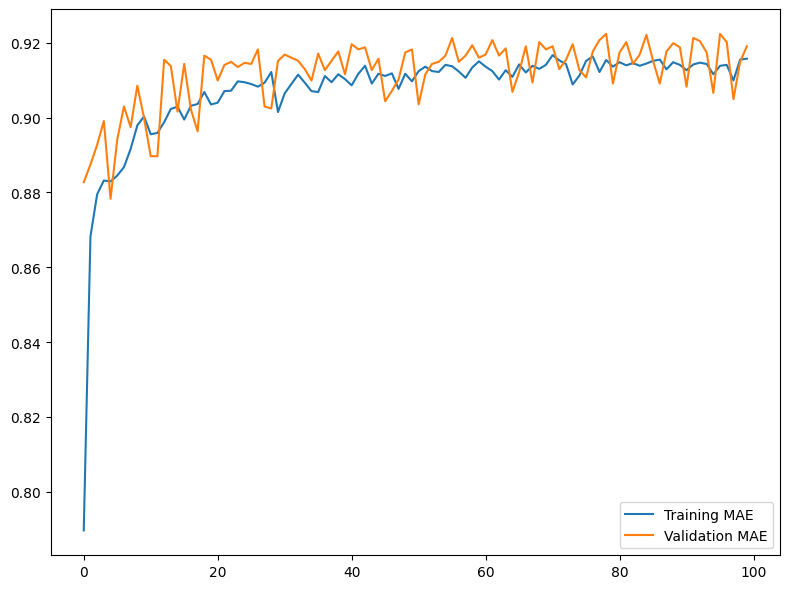

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint("loss.h5", save_best_only=True)

NN_model = Sequential()
NN_model.add(Dense(256, kernel_initializer='normal',input_dim = X_train_clf.shape[1], activation='relu')),
NN_model.add(Dense(1, kernel_initializer='normal',activation='sigmoid'))

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
NN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])


#history = NN_model.fit(X_train_clf, y_train_clf, validation_split=0.3, epochs=100) # 100 gives 60%

# evaluate the model
loss, accuracy, f1_score, precision, recall = NN_model.evaluate(X_test_clf, y_test_clf, verbose=0)

history = NN_model.fit(
    X_train_clf, y_train_clf,
    epochs=100,
    validation_split=0.3,
    callbacks=[checkpoint]
)

model_history = pd.DataFrame(history.history)
model_history['epoch'] = history.epoch

fig, ax = plt.subplots(1, figsize=(8,6))
num_epochs = model_history.shape[0]

ax.plot(np.arange(0, num_epochs), model_history["acc"],
        label="Training MAE")
ax.plot(np.arange(0, num_epochs), model_history["val_acc"],
        label="Validation MAE")
ax.legend()

plt.tight_layout()
plt.show()

# Predict and evaludate

In [ ]:
y_test_predict = NN_model.predict(X_test_clf)

186/186 [==============================] - 0s 2ms/step


In [ ]:
new_pred=[1 if x>0.1 else 0 for x in y_test_predict]

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(y_test_clf,new_pred))
print(classification_report(y_test_clf,new_pred))

[[1956  992]
 [  71 2902]]
              precision    recall  f1-score   support

           0       0.96      0.66      0.79      2948
           1       0.75      0.98      0.85      2973

    accuracy                           0.82      5921
   macro avg       0.86      0.82      0.82      5921
weighted avg       0.85      0.82      0.82      5921



# Test

In [ ]:
df_temp_test = df_test.copy()
df_test = df_test.drop(['Feature_Total_Incurred_Amount'], axis =1)
y_train_predict_on_new_data = NN_model.predict(df_test)
new_test_pred=[1 if x>0.1 else 0 for x in y_train_predict_on_new_data]
df_temp_test['Prediction'] = new_test_pred

210/210 [==============================] - 0s 1ms/step


In [ ]:
df_temp_test.to_csv('/content/drive/MyDrive/Colab Notebooks/testpredictions.csv')

In [ ]:
y_train_predict = NN_model.predict(X_train_clf)
new_pred_train=[1 if x>0.1 else 0 for x in y_train_predict]

376/376 [==============================] - 1s 2ms/step


In [ ]:
df_new = y_test_clf.copy()
df_new['Predictions'] = new_pred
df_new.head()

,LargeLossFlag,Predictions
1831,0,0
12612,1,1
15026,1,1
1675,0,0
1761,0,0


In [ ]:
## preparing for linear regression down below---

In [ ]:
temp_df = df[['Feature_Total_Incurred_Amount']]
X_train_temp_df, X_test_temp_df = train_test_split(temp_df, test_size=0.33, random_state=1)

In [ ]:
X_train_clf['Feature_Total_Incurred_Amount'] = X_train_temp_df['Feature_Total_Incurred_Amount']
X_test_clf['Feature_Total_Incurred_Amount'] = X_test_temp_df['Feature_Total_Incurred_Amount']

In [ ]:
X_test_clf['Clf_largeloss_identified'] = new_pred
X_test_clf['y_test_actual'] = y_test_clf

In [ ]:
x_test_predicted_true = X_test_clf[X_test_clf['Clf_largeloss_identified']==1 ]
x_test_predict_actual_true = x_test_predicted_true[x_test_predicted_true['y_test_actual']==1 ]

In [ ]:
x_test_predict_actual_true.shape

(68, 29)

In [ ]:
X_train_clf['Clf_largeloss_identified'] = new_pred_train
X_train_clf['y_test_actual'] = y_train_clf
x_train_predicted_true = X_train_clf[X_train_clf['Clf_largeloss_identified']==1 ]
x_train_predict_actual_true = x_train_predicted_true[x_train_predicted_true['y_test_actual']==1 ]

In [ ]:
y_train_clf = x_train_predict_actual_true['Feature_Total_Incurred_Amount']
y_test_clf = x_test_predict_actual_true['Feature_Total_Incurred_Amount']

In [ ]:
x_train_predict_actual_true = x_train_predict_actual_true.drop(['Clf_largeloss_identified','y_test_actual','Feature_Total_Incurred_Amount'], axis = 1)
x_test_predict_actual_true = x_test_predict_actual_true.drop(['Clf_largeloss_identified','y_test_actual','Feature_Total_Incurred_Amount'], axis = 1)

In [ ]:
x_train_predict_actual_true.shape

(171, 26)

In [ ]:
from sklearn.linear_model import LinearRegression
model_reg = LinearRegression()
model_reg.fit(x_train_predict_actual_true, y_train_clf)
yhat = model_reg.predict(x_test_predict_actual_true)
mae = mean_absolute_error(y_test_clf, yhat)
print('Mean Absolute error from model: %.3f' % mae)

Mean Absolute error from model: 56864.701


In [ ]:
y_test_clf_arry = y_test_clf.values

In [ ]:
df_results = pd.DataFrame()
df_results['yhat'] = yhat
df_results['ytest_clf_actual'] = y_test_clf_arry
df_results

,yhat,ytest_clf_actual
0,218517.247129,202998.60
1,238030.995410,209906.62
2,245654.347498,197319.85
3,245832.132309,298376.56
4,228461.303314,204967.95
...,...,...
63,227240.043377,188438.15
64,226913.685265,153557.20
65,253473.199813,255843.07
66,200520.638440,197614.36


In [ ]:
y_train_clf.sort_values( ascending= False)

79     391293.77
81     390671.88
82     390088.22
83     388841.60
84     385622.11
         ...    
506    151374.84
508    151041.58
510    150663.11
511    150371.76
514    150094.96
Name: Feature_Total_Incurred_Amount, Length: 171, dtype: float64

In [ ]:
df_results.sort_values(by = 'ytest_clf_actual', ascending= False)

,yhat,ytest_clf_actual
9,214656.875120,384762.41
10,219620.964234,375071.70
29,231140.553005,349425.26
54,264269.634757,348229.08
36,248086.514935,344223.82
...,...,...
30,232829.815030,155012.23
55,235077.817666,154829.96
64,226913.685265,153557.20
32,252490.785180,150323.25


import numpy as np
from google.colab import autoviz
df_8707827213032625727 = autoviz.get_df('df_8707827213032625727')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_8707827213032625727, *['yhat'], **{})
chart

import numpy as np
from google.colab import autoviz
df_8707827213032625727 = autoviz.get_df('df_8707827213032625727')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_8707827213032625727, *['ytest_clf_actual'], **{})
chart

import numpy as np
from google.colab import autoviz
df_8707827213032625727 = autoviz.get_df('df_8707827213032625727')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_8707827213032625727, *['yhat'], **{})
chart

import numpy as np
from google.colab import autoviz
df_8707827213032625727 = autoviz.get_df('df_8707827213032625727')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_8707827213032625727, *['ytest_clf_actual'], **{})
chart

import numpy as np
from google.colab import autoviz
df_8707827213032625727 = autoviz.get_df('df_8707827213032625727')

def scatter_plots(df, colname_pairs, scatter_plot_size=2.5, size=8, alpha=.6):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * scatter_plot_size, scatter_plot_size))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    ax.scatter(df[x_colname], df[y_colname], s=size, alpha=alpha)
    plt.xlabel(x_colname)
    plt.ylabel(y_colname)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df_8707827213032625727, *[[['yhat', 'ytest_clf_actual']]], **{})
chart

In [ ]:
df.sort_values(by = 'Feature_Total_Incurred_Amount', ascending=False)

,Claim_Lag_Time,Claimant_Age_at_Time_of_Accident,Surgery_Required_Flag,Feature_Total_Incurred_Amount,VL,NI,M,F,MULTIPLE BODY PARTS,LOW BACK AREA (INCLUDING LUMBAR & LUMBO-SACRAL),...,MECHANIC,TRUCK DRIVER,BUS DRIVER,EMT,MONITOR,Mover,SCHOOL BUS DRIVER,Helper,Mechanic,LargeLossFlag
79,5,63.0,1,391293.77,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
80,0,42.0,0,390880.06,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
81,19,63.0,1,390671.88,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
82,4,46.0,1,390088.22,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
83,9,47.0,1,388841.60,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9050,7,43.0,0,0.00,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9051,0,49.0,0,0.00,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9486,10,24.0,0,-55.13,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9487,4,67.0,0,-126.46,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
